In [1]:
import numpy as np
import glob
import pandas as pd
pd.set_option('display.max_columns', 200)
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.linear_model import LinearRegression,HuberRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 6]
%config InlineBackend.figure_format='retina'

In [2]:
df = pd.read_csv(r'C:\Users\u23e00\NOx_prediction\data\raw\complete_data_29_10.csv')
df = df.drop('Unnamed: 0', axis=1)
df['NOx'] = df['GPiS_NO'] + df['GPiS_NO2']
df

,GPiS_NO,AMB_Humidity,AMB_Pressure,AMB_Temperature,EFM_AbsolutePressure,EFM_ExhaustGasDiffPress,EFM_ExhaustGasFlowMass,EFM_ExhaustGasFlowVol,EFM_ExhaustGasTemp,OBD_Accelerator_Pedal_Position_D_(PID_49),OBD_Barometric_Pressure_(PID_33),OBD_Engine_Coolant_Temperature_(PID_05),OBD_Engine_RPM_(PID_0C),OBD_Intake_Air_Temperature_(PID_0F),OBD_Vehicle_Speed_Sensor_(PID_0D),GPiS_NO2,accel,NOx
0,0.514287,31.845775,962.843895,21.151974,984.010010,0.00000,0.02200,0.000000,17.900000,14.9036,96.0,20.0,0.0,22.0,0.0,0.317213,NaN,0.831500
1,0.592000,31.918452,962.843895,21.181047,984.017822,0.00000,0.05398,0.000000,17.978001,14.9036,96.0,20.0,0.0,22.0,0.0,0.326000,0.0,0.918000
2,0.593300,31.894226,962.843895,21.151974,984.100220,0.00000,0.02171,0.000000,18.100000,14.9036,96.0,20.0,0.0,22.0,0.0,0.330225,0.0,0.923525
3,0.595300,31.845775,962.843895,21.122906,984.210022,0.00000,-0.04421,0.000000,18.100000,14.9036,96.0,20.0,0.0,22.0,0.0,0.336725,0.0,0.932025
4,0.596975,31.773098,962.843895,21.093832,984.210022,0.00000,-0.04077,0.000000,18.100000,14.9036,96.0,20.0,0.0,22.0,0.0,0.343225,0.0,0.940200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496225,0.182830,17.213895,974.436712,16.646320,976.128540,-0.00300,-1.28990,-0.000300,10.400000,14.8998,97.0,17.0,0.0,20.0,0.0,-0.883100,0.0,-0.700270
496226,0.171620,17.190055,974.675131,16.674925,976.190002,-0.00300,-1.38400,-0.000300,10.400000,14.8998,97.0,17.0,0.0,20.0,0.0,-0.878390,0.0,-0.706770
496227,0.160620,17.213895,974.436712,16.674925,976.190002,-0.00300,-1.34970,-0.000300,10.400000,14.8998,97.0,17.0,0.0,20.0,0.0,-0.873890,0.0,-0.713270
496228,0.149330,17.213895,974.675131,16.674925,976.197022,-0.00265,-1.21285,-0.000265,10.400000,14.8998,97.0,17.0,0.0,20.0,0.0,-0.869390,0.0,-0.720060


<AxesSubplot:>

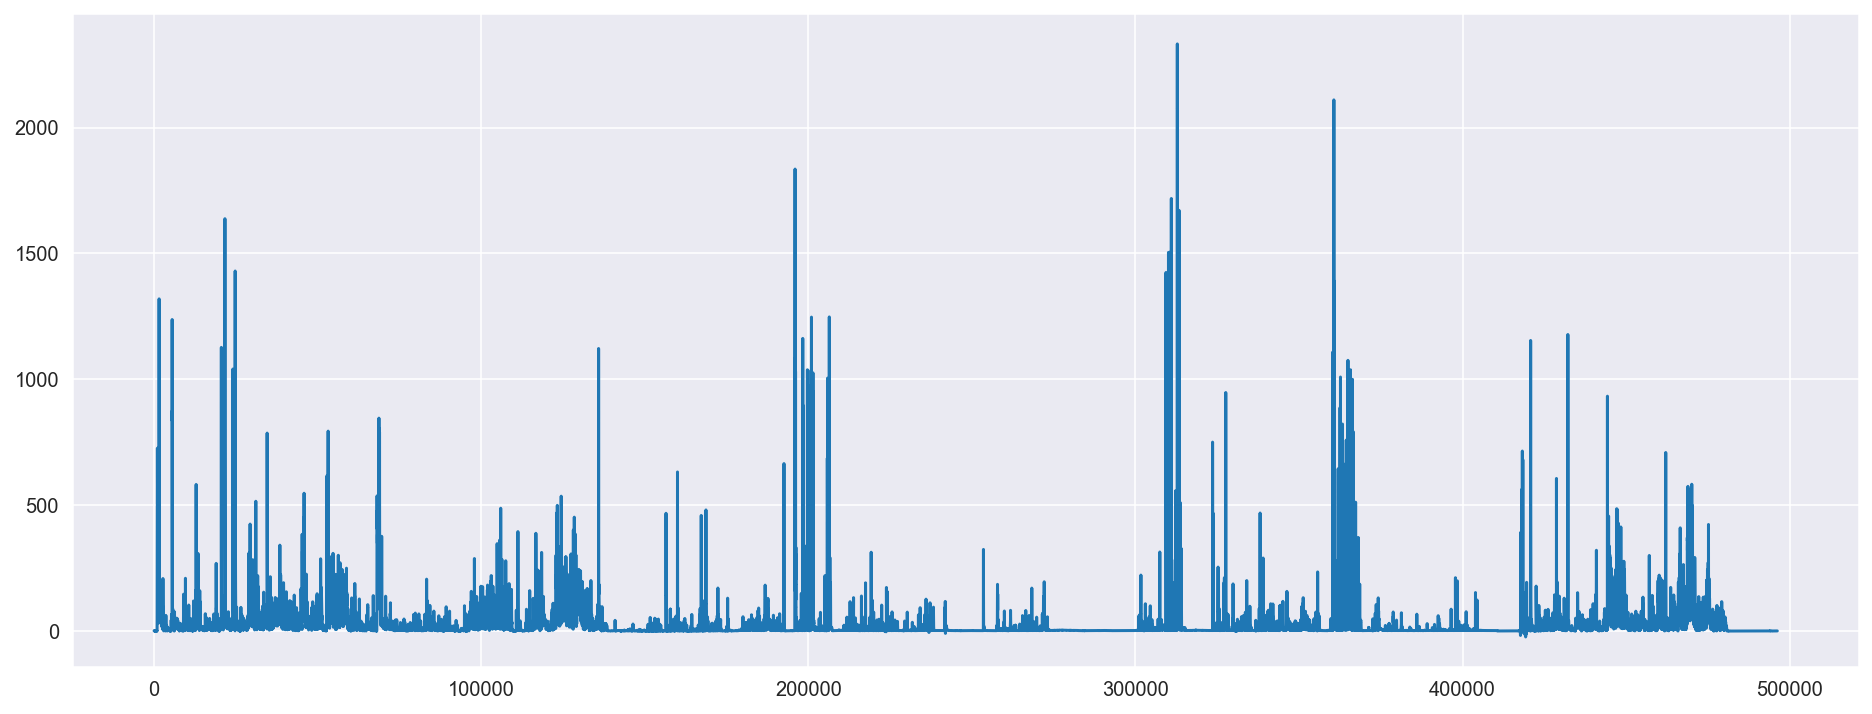

In [3]:
df['GPiS_NO'].plot()

In [4]:
df = df[(df['GPiS_NO']<500) &(df['GPiS_NO']>0)][:-2000]

In [5]:
channels_model = ['GPiS_NO','AMB_Humidity', 'AMB_Pressure', 'AMB_Temperature','EFM_ExhaustGasTemp',
                  'OBD_Accelerator_Pedal_Position_D_(PID_49)','OBD_Engine_Coolant_Temperature_(PID_05)',
                  'OBD_Engine_RPM_(PID_0C)','OBD_Vehicle_Speed_Sensor_(PID_0D)','accel']

In [6]:
df = df[channels_model].dropna()
df = df[df['OBD_Engine_Coolant_Temperature_(PID_05)']>0]
df

,GPiS_NO,AMB_Humidity,AMB_Pressure,AMB_Temperature,EFM_ExhaustGasTemp,OBD_Accelerator_Pedal_Position_D_(PID_49),OBD_Engine_Coolant_Temperature_(PID_05),OBD_Engine_RPM_(PID_0C),OBD_Vehicle_Speed_Sensor_(PID_0D),accel
1,0.592000,31.918452,962.843895,21.181047,17.978001,14.903600,20.0,0.00,0.0,0.0
2,0.593300,31.894226,962.843895,21.151974,18.100000,14.903600,20.0,0.00,0.0,0.0
3,0.595300,31.845775,962.843895,21.122906,18.100000,14.903600,20.0,0.00,0.0,0.0
4,0.596975,31.773098,962.843895,21.093832,18.100000,14.903600,20.0,0.00,0.0,0.0
5,0.598475,31.797323,962.601614,21.122906,18.100000,14.903600,20.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
480447,18.639870,42.341800,976.820755,-4.895972,68.288002,18.820801,95.0,1215.00,26.0,0.0
480448,17.270870,42.341800,976.820755,-4.867365,68.400002,18.820801,95.0,1215.00,26.0,0.0
480449,17.113434,42.365642,977.059174,-4.867365,68.400002,18.820801,95.0,1215.00,26.0,0.0
480450,16.955997,42.341800,976.820755,-4.867365,68.400002,21.173401,95.0,1215.00,26.0,0.0


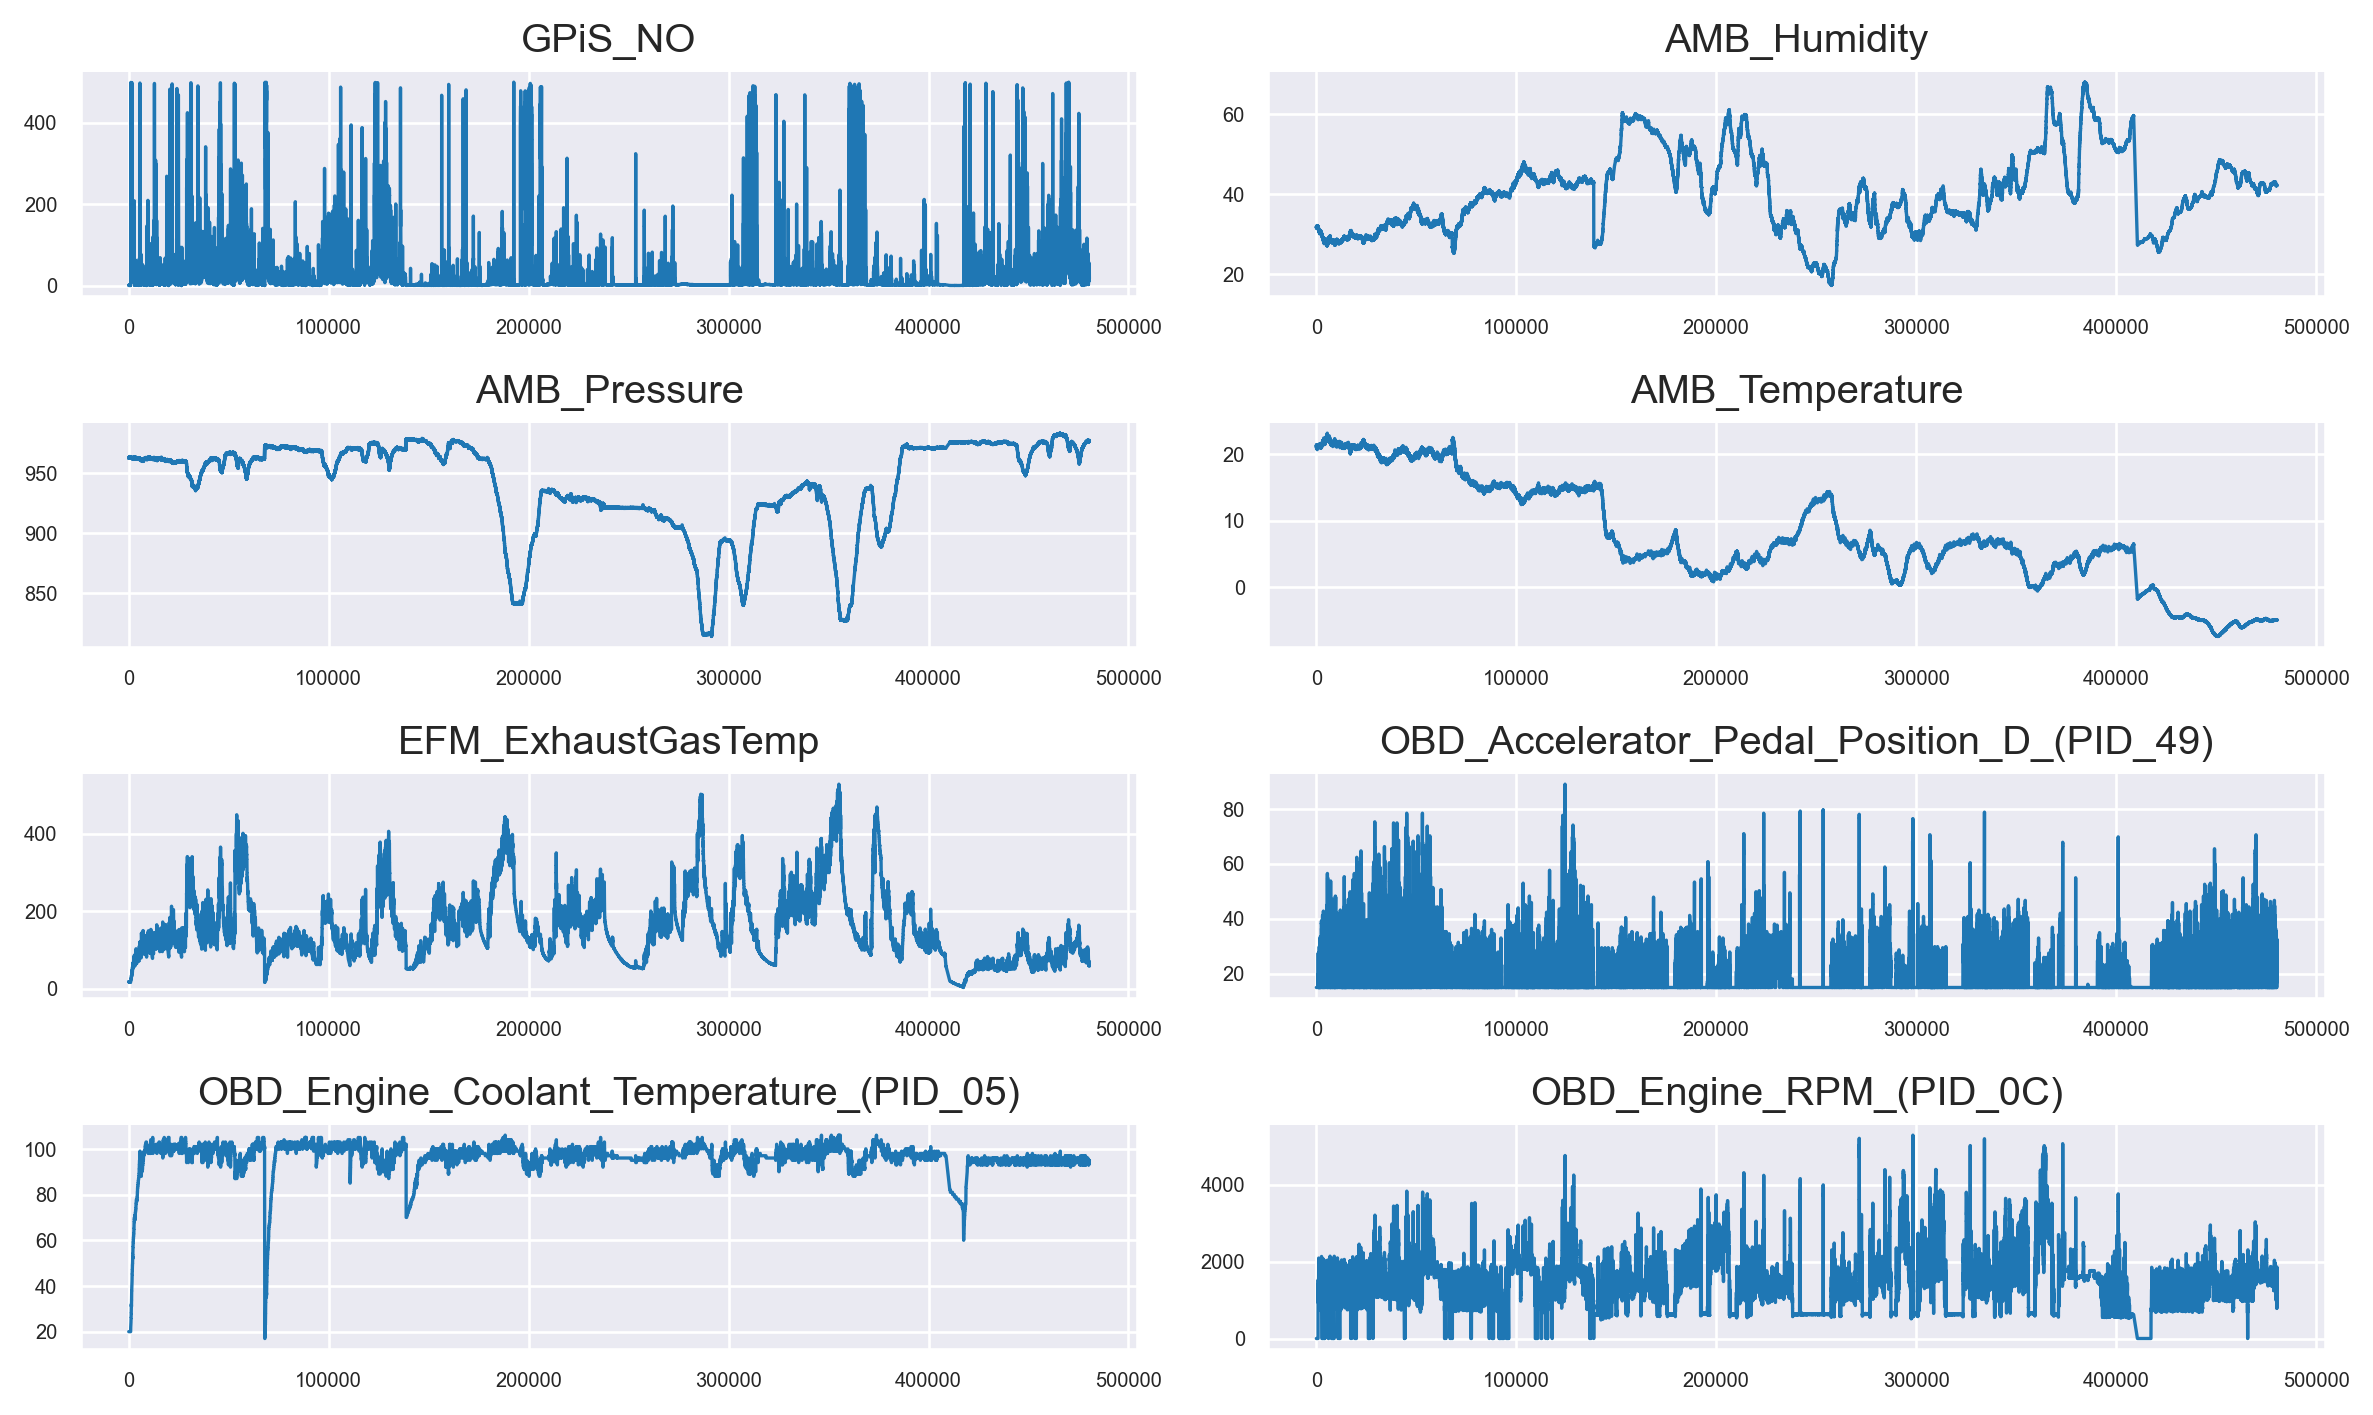

In [7]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data,linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [8]:
reduce_by = 10
df_down = df.groupby(df.index//reduce_by).mean()
df_down.shape

(46359, 10)

In [9]:
# convert time-series data to supervised data
def series_to_supervised(data, n_in, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for j in range(0,n_vars):
        for i in range(n_in[j], 0, -1):
            cols.append(df[j].shift(i))
            names += [('var%d(t-%d)' % (j+1, i))]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [10]:
def split_data(data, n_lag, n_features,flag):
    n_obs = sum(n_lag)
    reframed = series_to_supervised(data, n_lag, 1)
    if flag==1 :
        print(reframed.head())
    # split into train and test sets
    values = reframed.values
    n_train = int(train_percent*(len(data)))
    train = values[:n_train, :]
    test = values[n_train:, :]
    # split into input and outputs
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    print(train_X.shape, len(train_X), train_y.shape)
    print(test_X.shape)
    return train_X, train_y, test_X, test_y

In [11]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [12]:
def DT(data, n_lag, n_features,flag):
    # Fit Linear Regression
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    # include or exclude NO
    train_X = pd.DataFrame(train_X).drop([0,1], axis=1).values
    test_X = pd.DataFrame(test_X).drop([0,1], axis=1).values
    print("new_train shape :",len(train_X[0]))
    model = DecisionTreeRegressor()
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mse = np.sqrt(mean_squared_error(prediction, test_y))
    return prediction, mse,test_y, model

In [13]:
def plot(y1,y2,title):
    x = []
    for i in range(0,len(y1)):
        x.append(i+1)
    plt.plot(x, y1, label = "Actual")   
    plt.plot(x, y2, label = "Predicted") 
    plt.xlabel('Index') 
    plt.ylabel('NO Emission (ppm)') 
    plt.title(title) 
    plt.legend()    
    plt.show()

In [14]:
MSE = {}
train_percent =.9
n_lag = []
n_features = df.shape[1]
for i in range(0,n_features):
    if i%2==0:
        n_lag.append(2)
    else:
        n_lag.append(3)

In [15]:
prediction_dt, MSE['DT'],test_dt, model_dt = DT(df.dropna().values, n_lag, n_features,0)
print("RMSE for DT method: " + str(MSE['DT']))

(414766, 25) 414766 (414766,)
(46083, 25)
new_train shape : 23
RMSE for DT method: 90.20236446002075


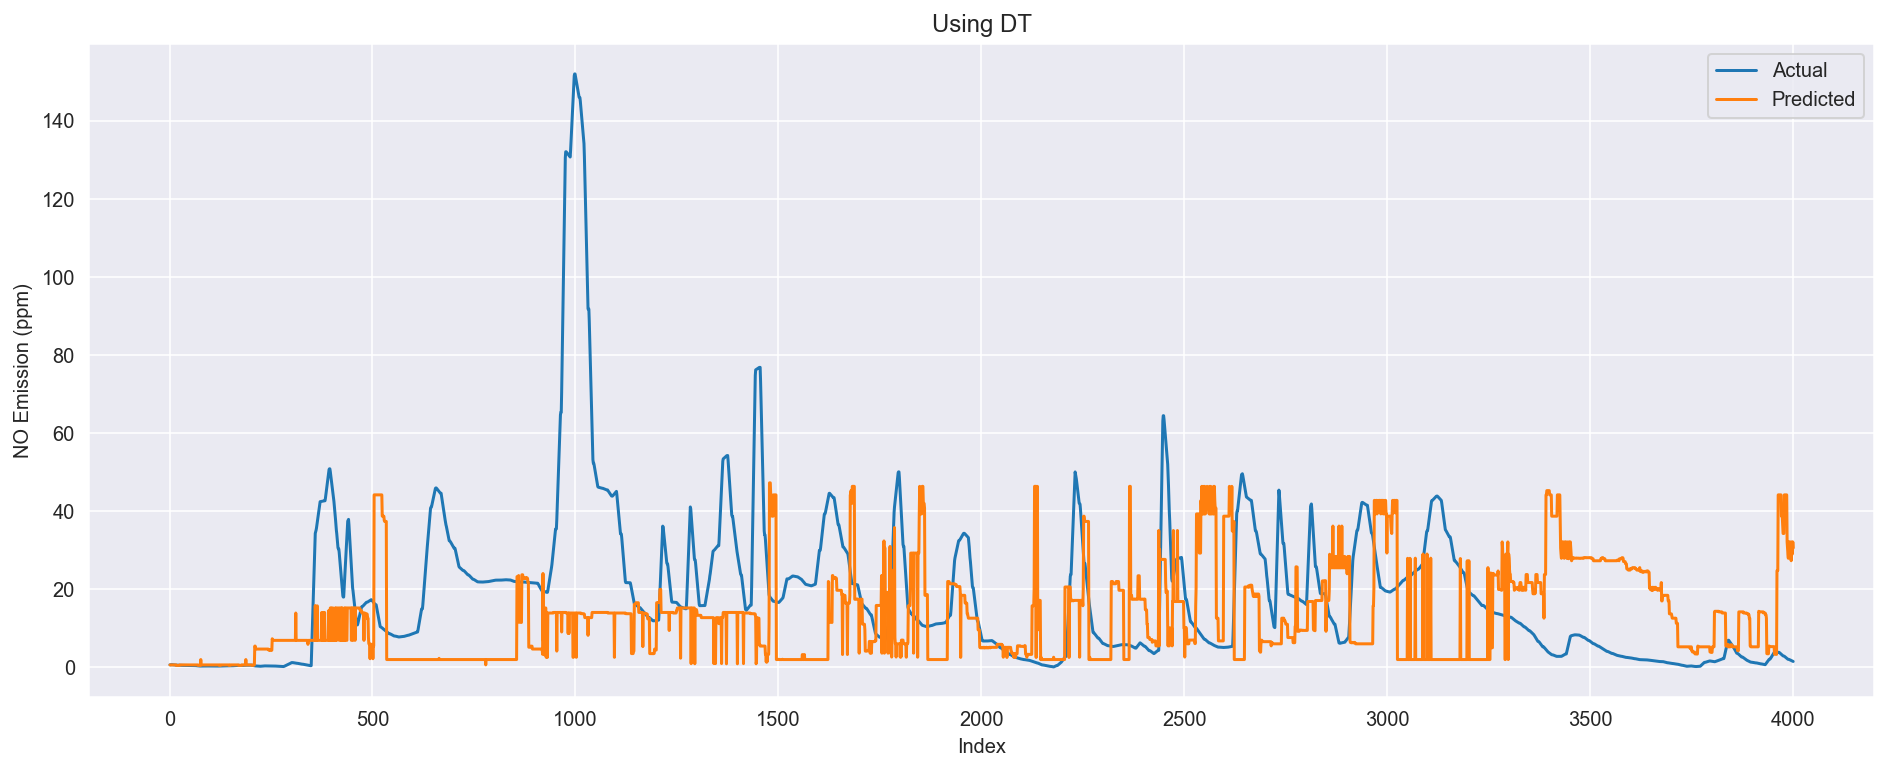

In [16]:
plot(test_dt[:4000], prediction_dt[:4000], 'Using DT')

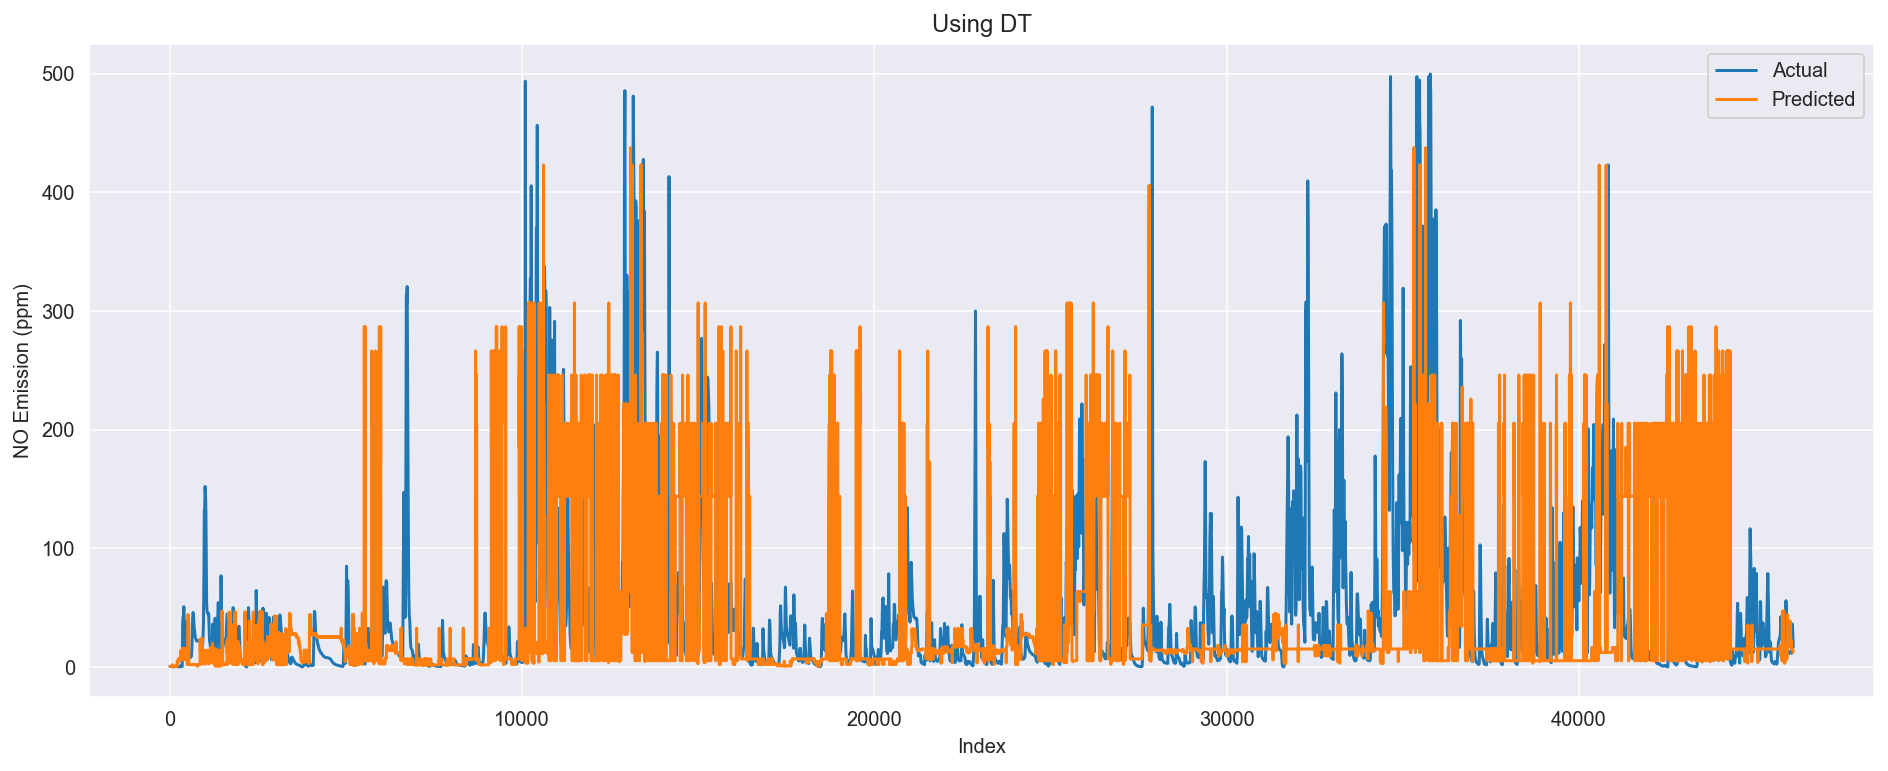

In [25]:
plot(test_dt, prediction_dt, 'Using DT')

(414766, 25) 414766 (414766,)
(46083, 25)
new_train shape : 23
RMSE for ExtraTree method: 92.12061873286876


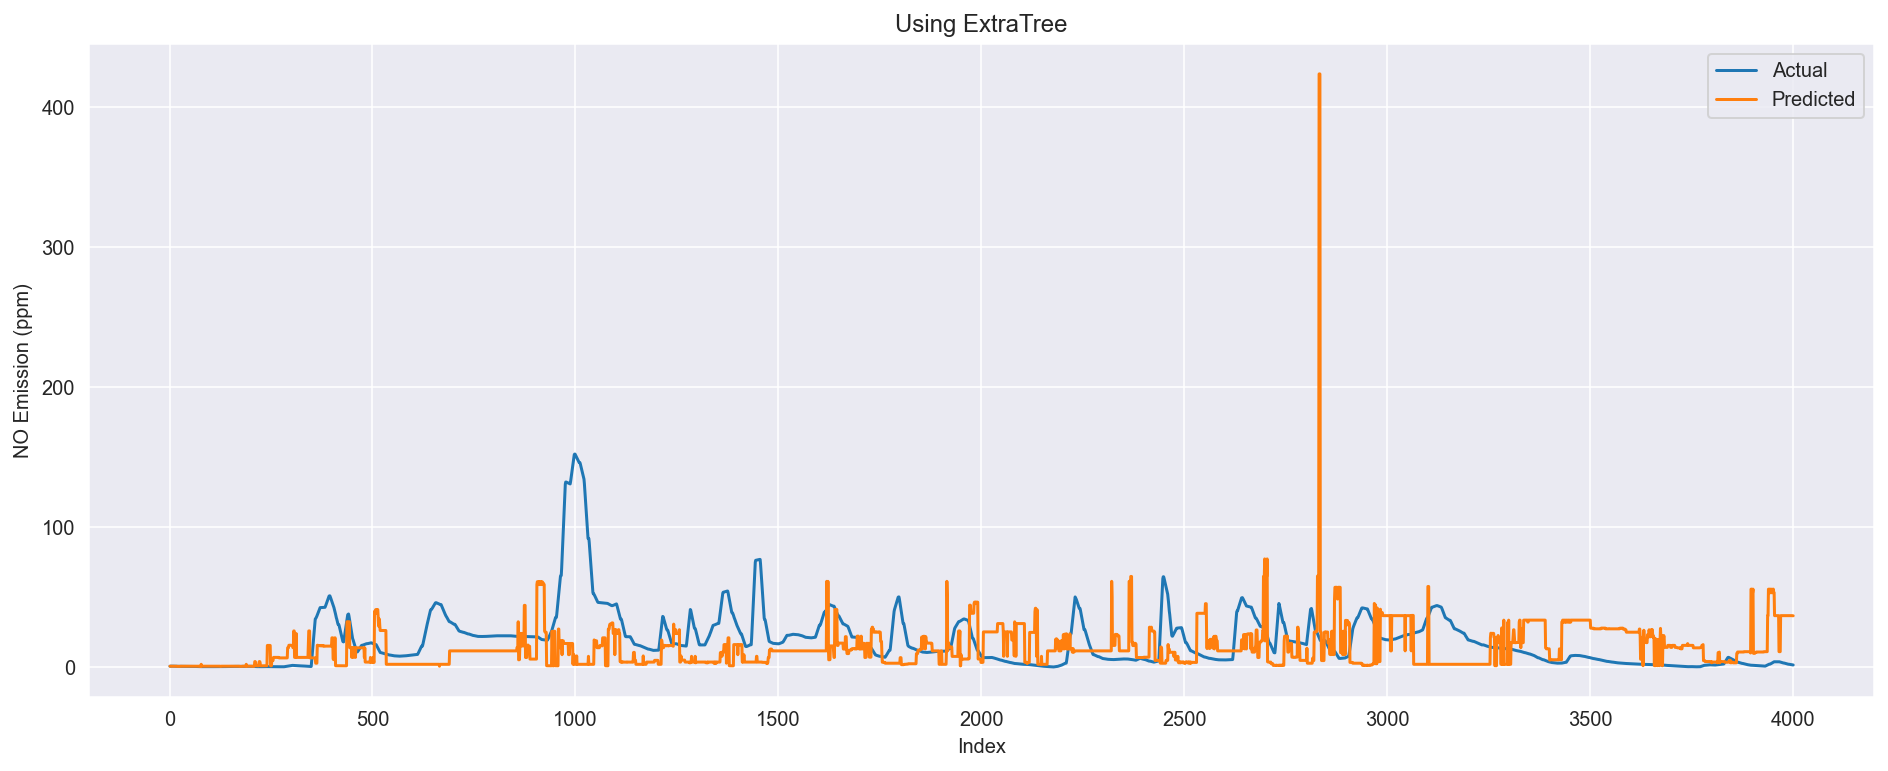

In [17]:
def ExtraTree(data, n_lag, n_features,flag):
    # Fit Linear Regression
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    # include or exclude NO
    train_X = pd.DataFrame(train_X).drop([0,1], axis=1).values
    test_X = pd.DataFrame(test_X).drop([0,1], axis=1).values
    print("new_train shape :",len(train_X[0]))
    model = ExtraTreeRegressor()
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mse = np.sqrt(mean_squared_error(prediction, test_y))
    return prediction, mse,test_y, model

prediction_et, MSE['ExtraTree'],test_et, model_et = ExtraTree(df.dropna().values, n_lag, n_features,0)
print("RMSE for ExtraTree method: " + str(MSE['ExtraTree']))
plot(test_et[:4000], prediction_et[:4000], 'Using ExtraTree')

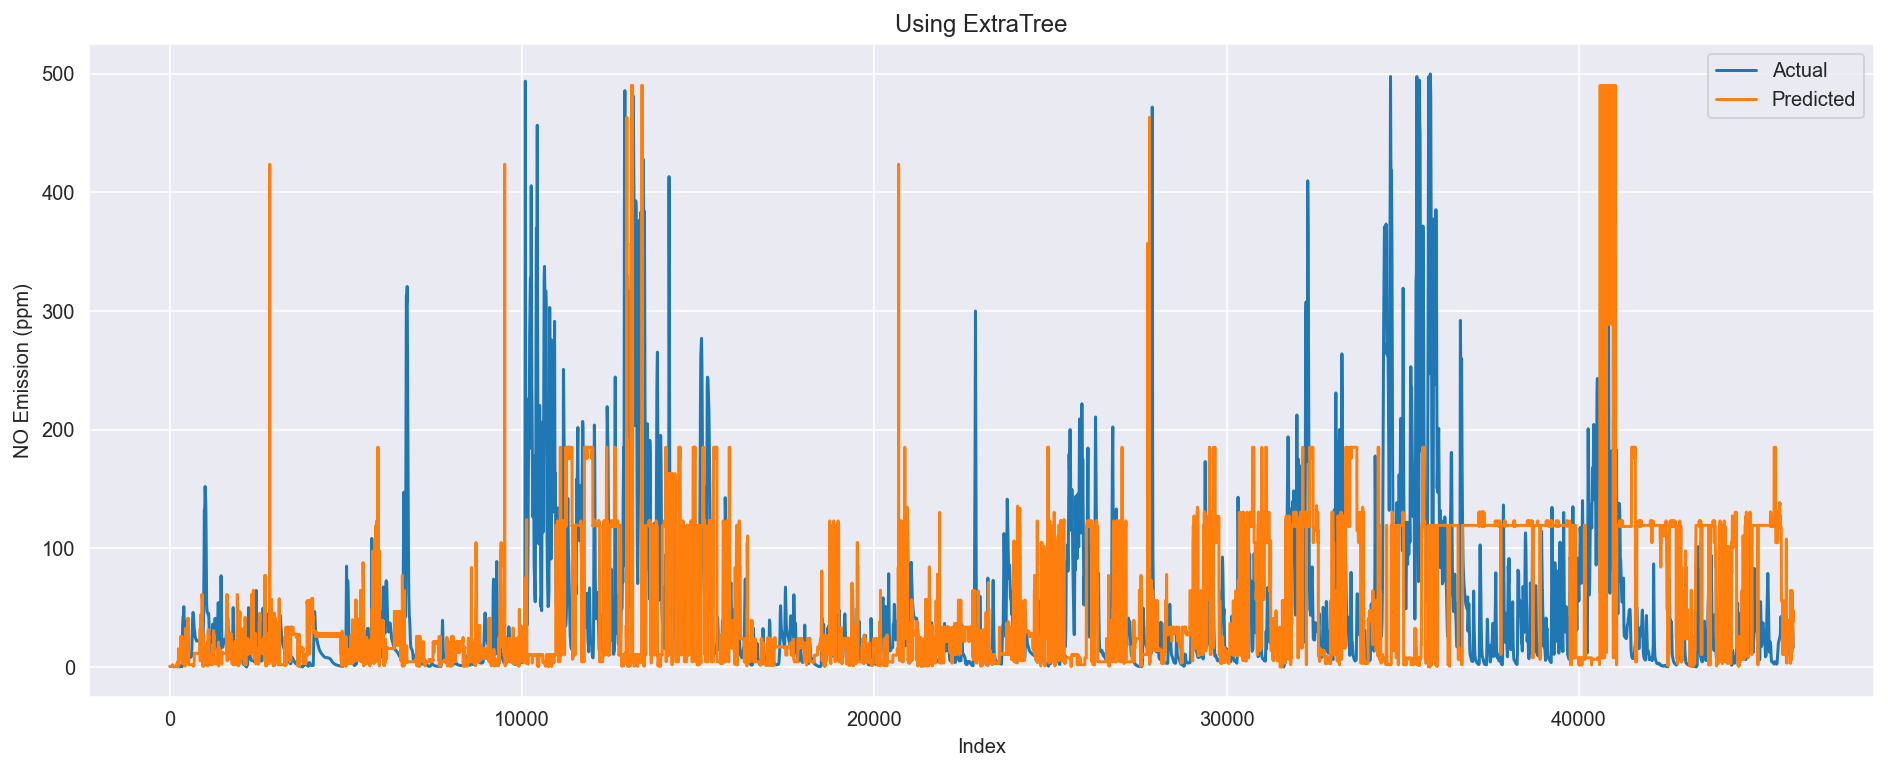

In [26]:
plot(test_et, prediction_et, 'Using ExtraTree')

In [19]:
n_trees = 100

(414766, 25) 414766 (414766,)
(46083, 25)
new_train shape : 25
RMSE for ADA method: 21.129114660222996


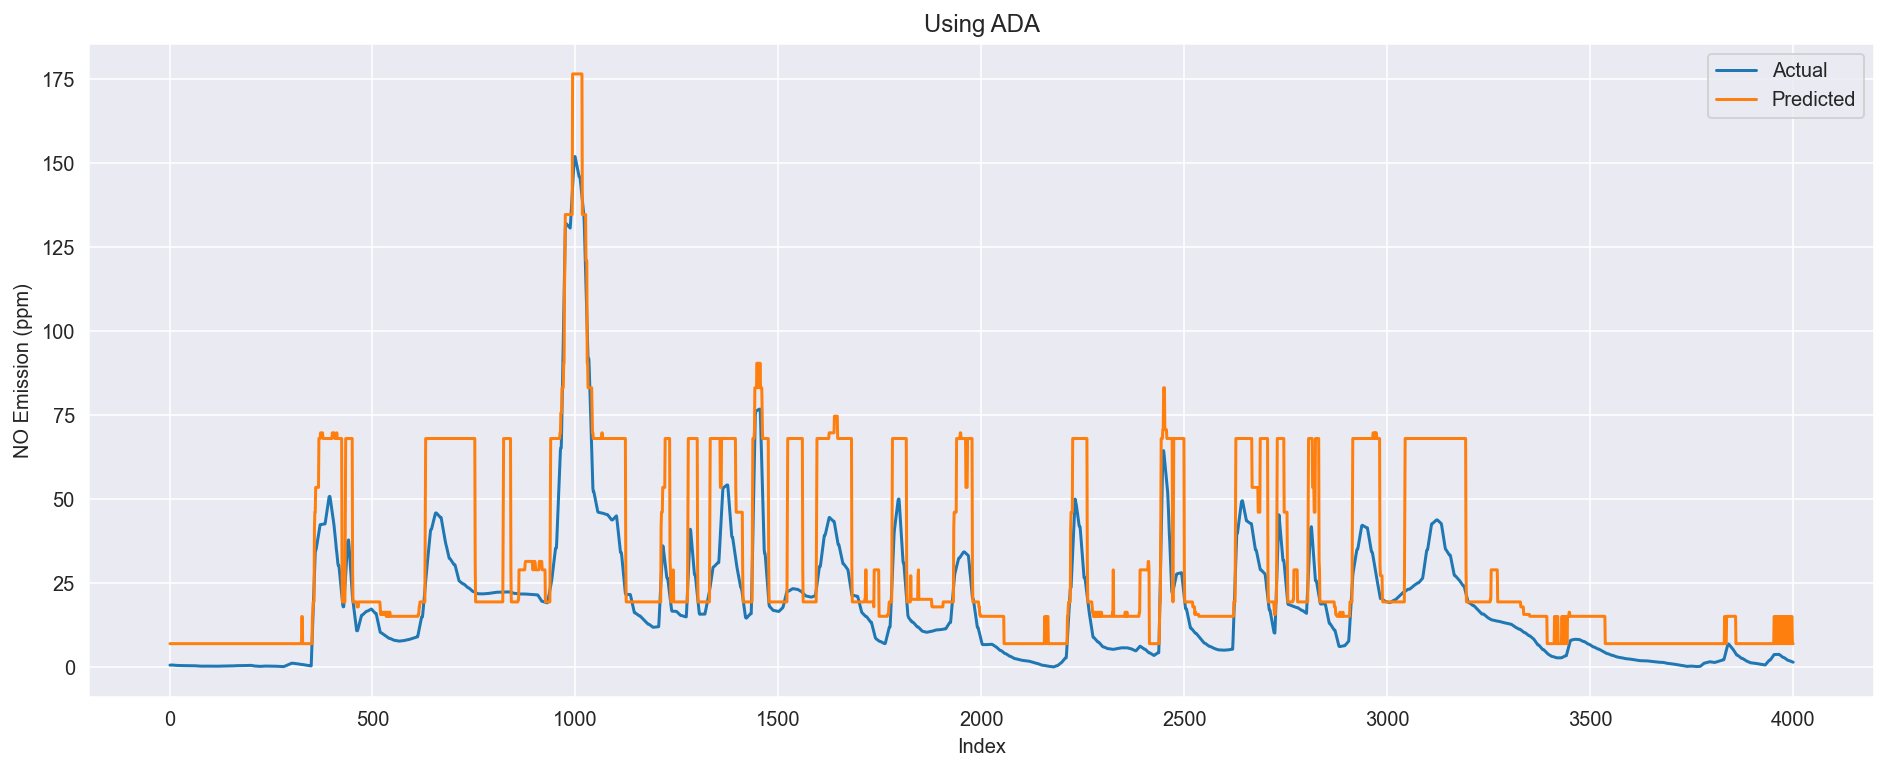

In [20]:
def ADA(data, n_lag, n_features,flag):
    # Fit Linear Regression
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    # include or exclude NO
#     train_X = pd.DataFrame(train_X).drop([0,1], axis=1).values
#     test_X = pd.DataFrame(test_X).drop([0,1], axis=1).values
    print("new_train shape :",len(train_X[0]))
    model = AdaBoostRegressor(n_estimators=n_trees)
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mse = np.sqrt(mean_squared_error(prediction, test_y))
    return prediction, mse,test_y, model

prediction_ada, MSE['ADA'],test_ada, model_ada = ADA(df.dropna().values, n_lag, n_features,0)
print("RMSE for ADA method: " + str(MSE['ADA']))
plot(test_ada[:4000], prediction_ada[:4000], 'Using ADA')

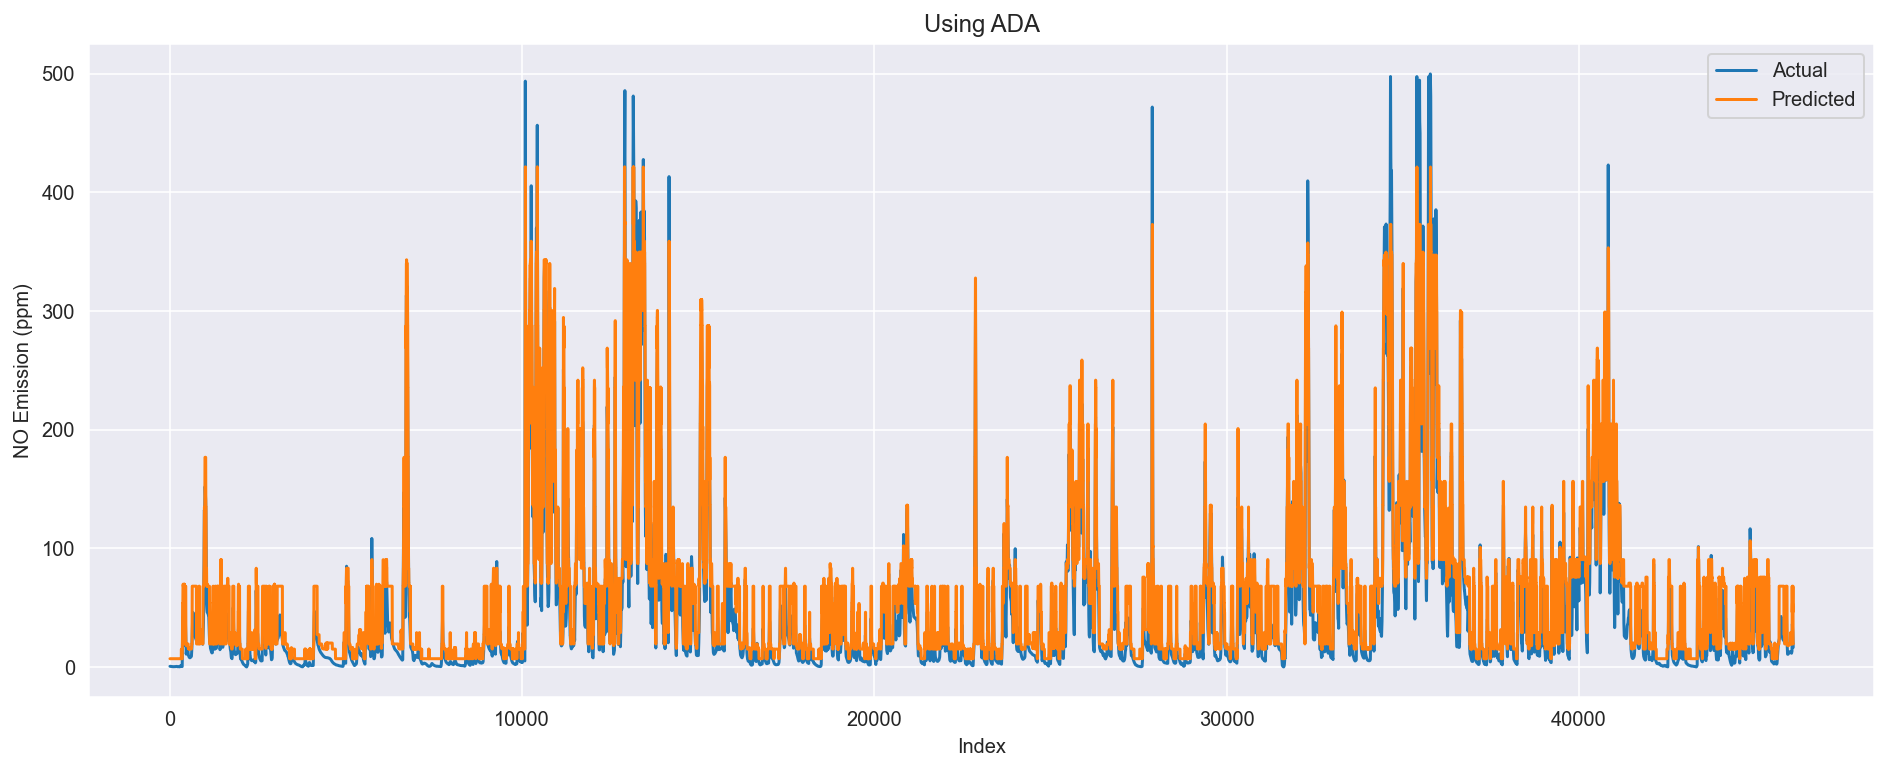

In [21]:
plot(test_ada, prediction_ada, 'Using ADA')

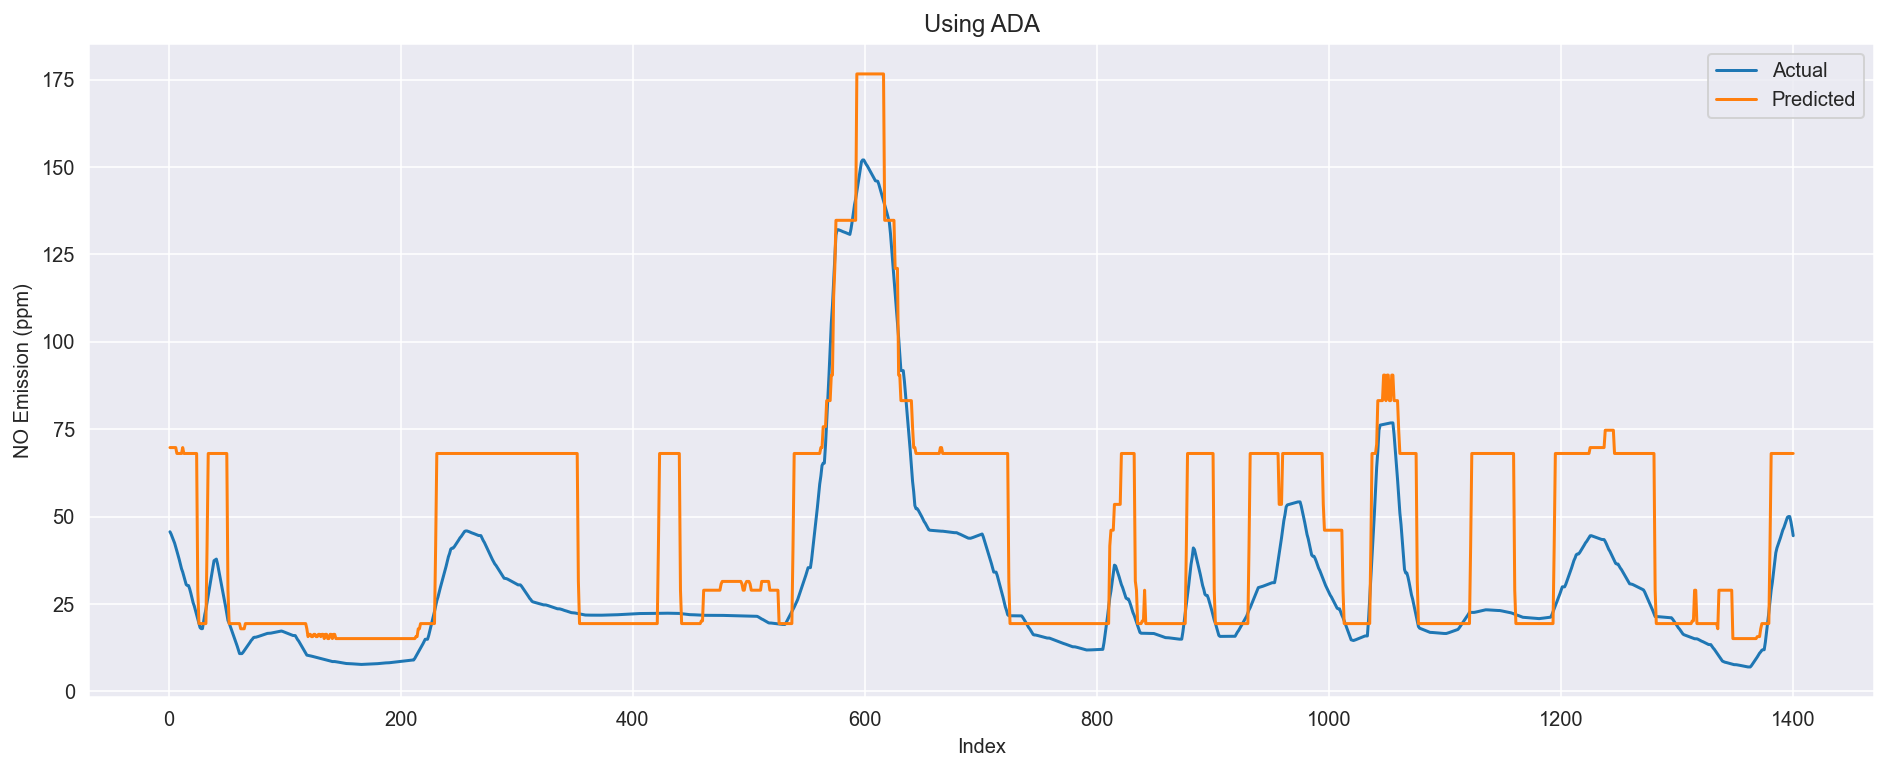

In [30]:
plot(test_ada[400:1800], prediction_ada[400:1800], 'Using ADA')

(41723, 25) 41723 (41723,)
(4633, 25)
new_train shape : 23
RMSE for SVR method: 82.41577652121926


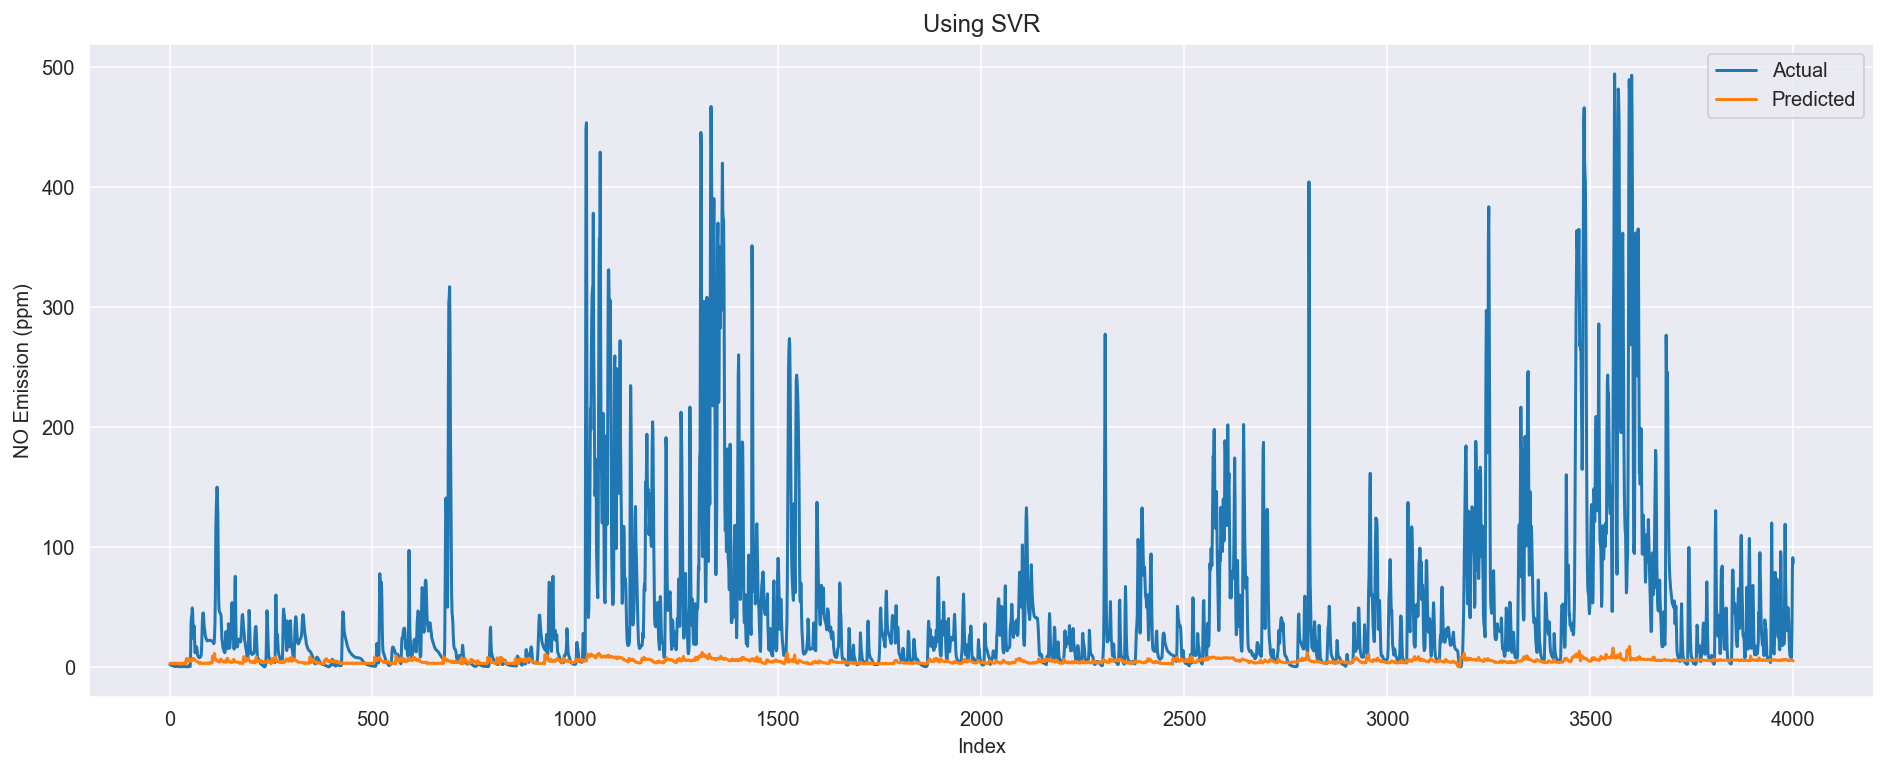

In [35]:
def SVR_(data, n_lag, n_features,flag):
    # Fit SVM
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    # include or exclude NO
    train_X = pd.DataFrame(train_X).drop([0,1], axis=1).values
    test_X = pd.DataFrame(test_X).drop([0,1], axis=1).values
    print("new_train shape :",len(train_X[0]))
    parameters = {'kernel': ('linear', 'rbf','poly'), 'C':[1.5, 10],'gamma': [1e-7, 1e-4],'epsilon':[0.1,0.2,0.5,0.3]}
    model = SVR()
    model = grid_search.GridSearchCV(model, parameters)
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mse = np.sqrt(mean_squared_error(prediction, test_y))
    return prediction, mse,test_y, model

prediction_svm, MSE['SVR'],test_svm, model_svm = SVR_(df_down.dropna().values, n_lag, n_features,0)
print("RMSE for SVR method: " + str(MSE['SVR']))
plot(test_svm[:4000], prediction_svm[:4000], 'Using SVR')

In [ ]:
parameters = {'kernel': ('linear', 'rbf','poly'), 'C':[1.5, 10],'gamma': [1e-7, 1e-4],'epsilon':[0.1,0.2,0.5,0.3]}
svr = svm.SVR()
clf = grid_search.GridSearchCV(svr, parameters)
clf.fit(X,y)

(414766, 25) 414766 (414766,)
(46083, 25)
new_train shape : 23
RMSE for RF method: 91.40067716013137


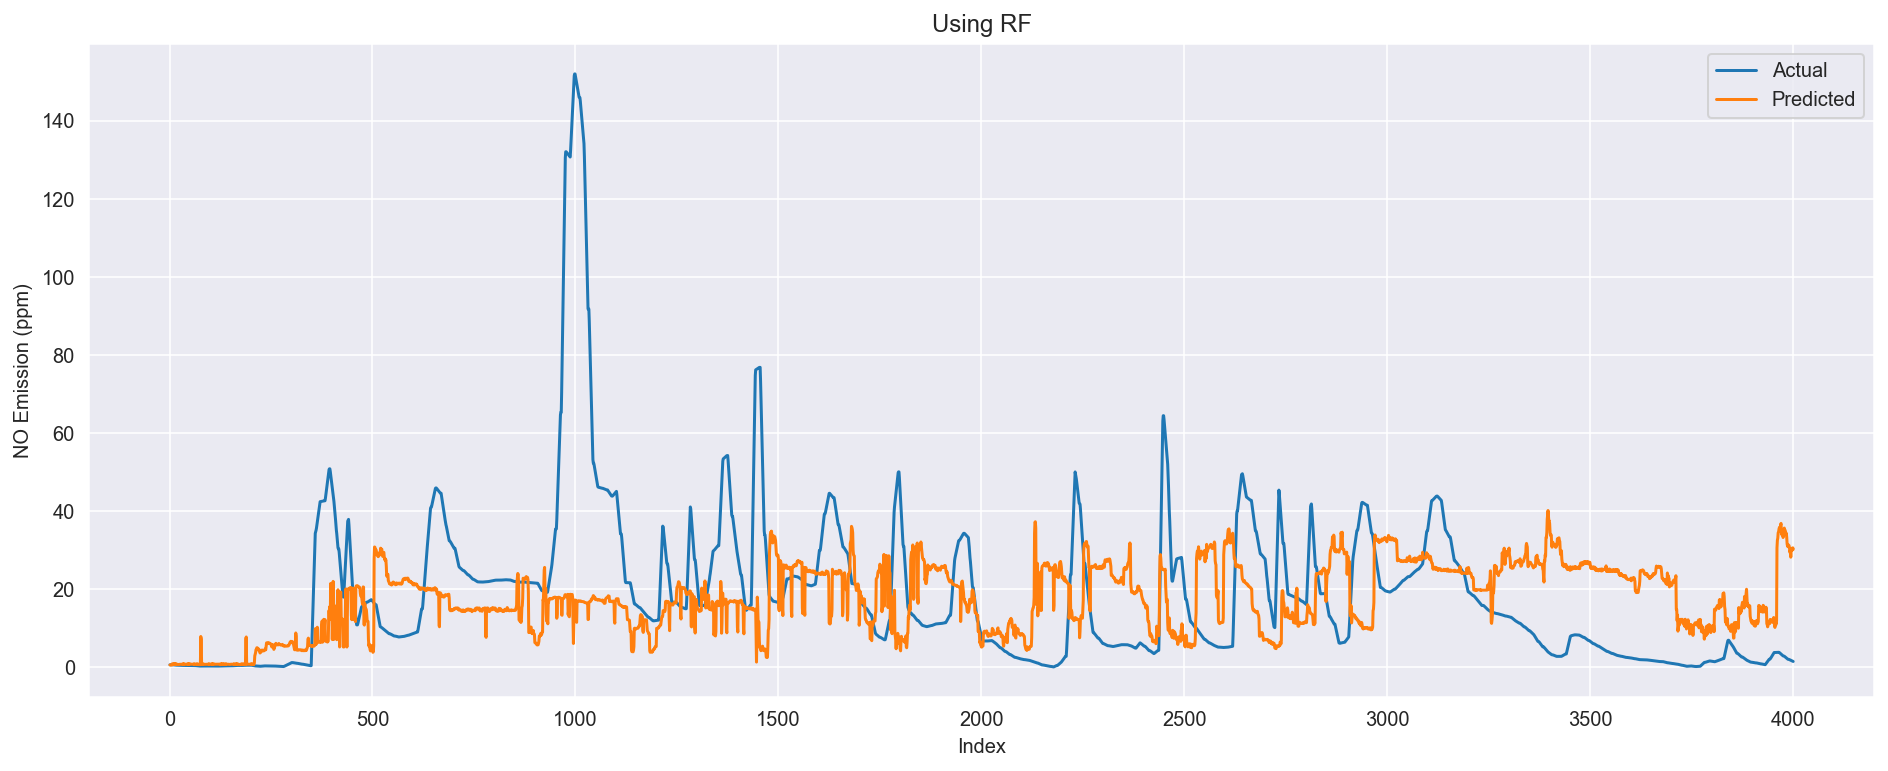

In [22]:
def RF(data, n_lag, n_features,flag):
    # Fit Linear Regression
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    # include or exclude NO
    train_X = pd.DataFrame(train_X).drop([0,1], axis=1).values
    test_X = pd.DataFrame(test_X).drop([0,1], axis=1).values
    print("new_train shape :",len(train_X[0]))
    model = RandomForestRegressor(n_estimators=n_trees)
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mse = np.sqrt(mean_squared_error(prediction, test_y))
    return prediction, mse,test_y, model

prediction_rf, MSE['RF'],test_rf, model_rf = RF(df.dropna().values, n_lag, n_features,0)
print("RMSE for RF method: " + str(MSE['RF']))
plot(test_rf[:4000], prediction_rf[:4000], 'Using RF')

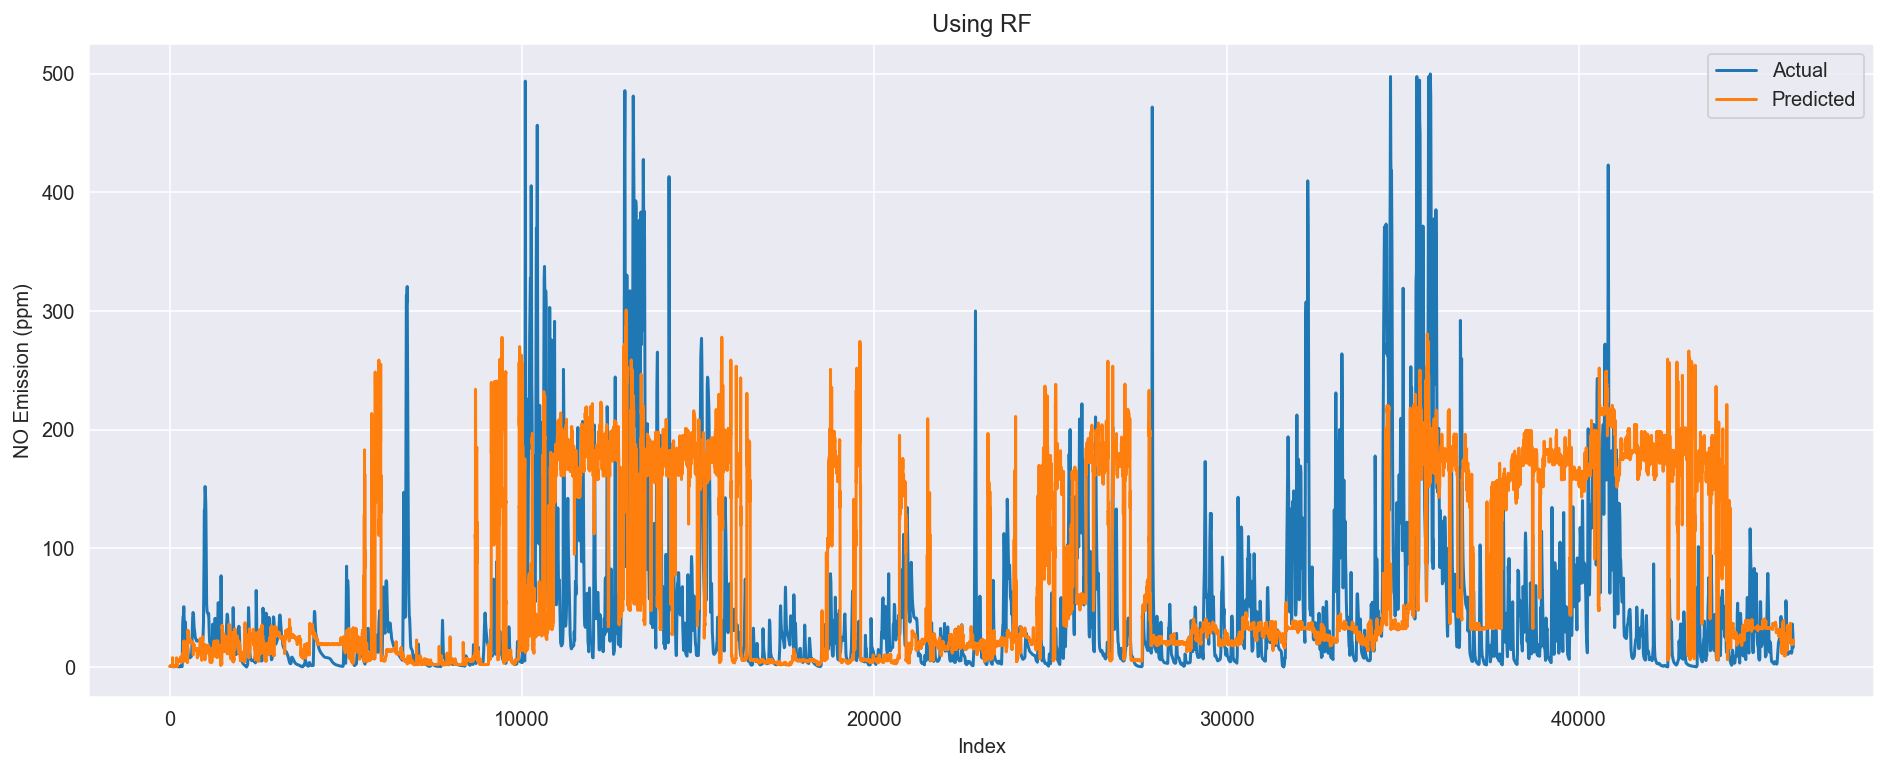

In [27]:
plot(test_rf, prediction_rf, 'Using RF')

(414766, 25) 414766 (414766,)
(46083, 25)
new_train shape : 23
RMSE for GBM method: 68.88619183857735


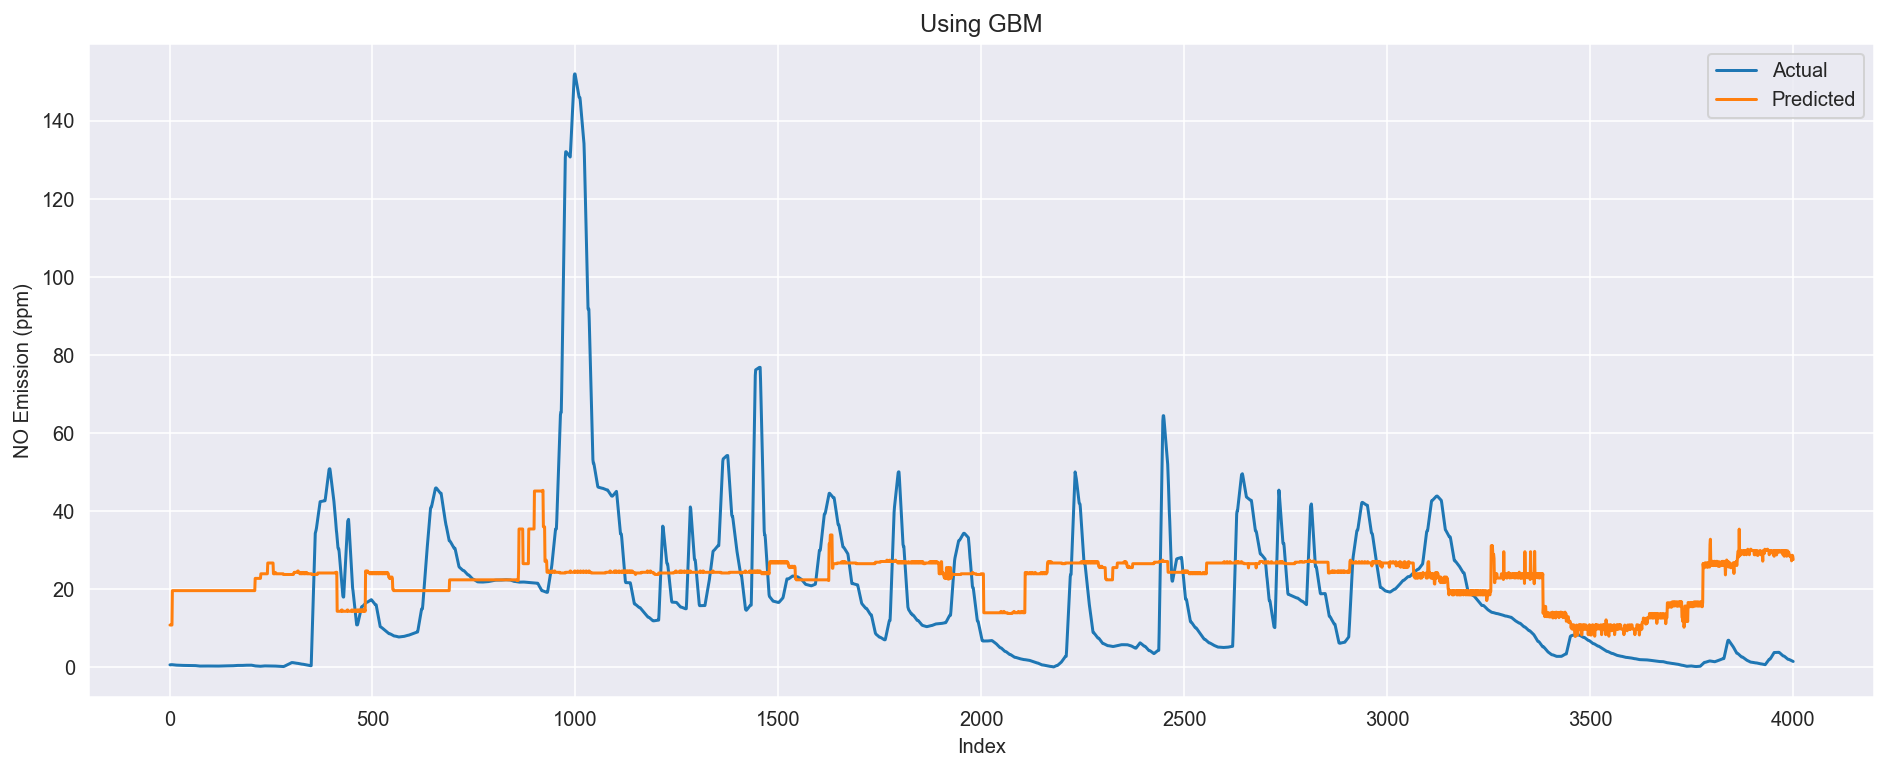

In [23]:
def GBM(data, n_lag, n_features,flag):
    # Fit Linear Regression
    train_X, train_y, test_X, test_y = split_data(data, n_lag, n_features,flag)
    # include or exclude NO
    train_X = pd.DataFrame(train_X).drop([0,1], axis=1).values
    test_X = pd.DataFrame(test_X).drop([0,1], axis=1).values
    print("new_train shape :",len(train_X[0]))
    model = GradientBoostingRegressor(n_estimators=n_trees)
    model.fit(train_X, train_y)
    prediction = model.predict(test_X)
    mse = np.sqrt(mean_squared_error(prediction, test_y))
    return prediction, mse,test_y, model

prediction_gbm, MSE['GBM'],test_gbm, model_gbm = GBM(df.dropna().values, n_lag, n_features,0)
print("RMSE for GBM method: " + str(MSE['GBM']))
plot(test_gbm[:4000], prediction_gbm[:4000], 'Using GBM')

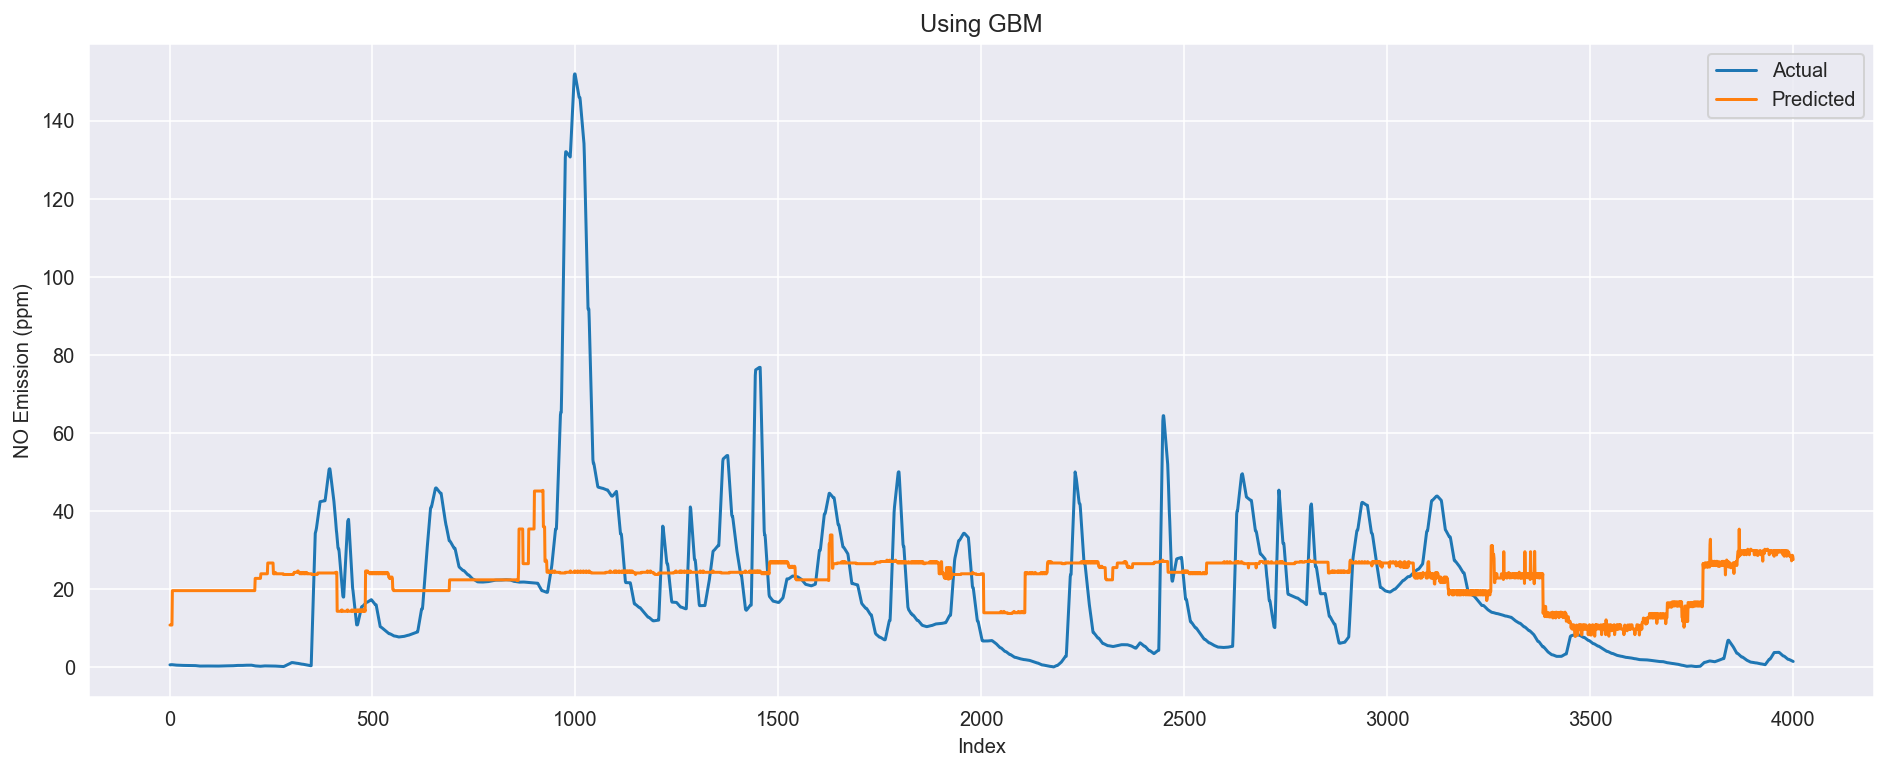

In [33]:
plot(test_gbm[:4000], prediction_gbm[:4000], 'Using GBM')